# Data ingestion
This notebook is used as a experimental playground for creating real-world emulating scenarios.
Some of them include
#### 1. Real coordinates of top 10 US cities by population
#### 2. Traffic generation according to population weightage (i.e. more traffic is generated from more populated cities)
#### 3. Housing market price emulation - The prices of housing market is assumed to follow Log-normal distribution.
#### this assumption is applied to generate random prices of houses across US.

## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from haversine import haversine
from collections import Counter
import json
import asyncio
import concurrent.futures
import requests
import nest_asyncio
import numpy as np
import sqlalchemy

plt.rcParams["figure.figsize"] = (12,9)
nest_asyncio.apply()

## Create top 10 US cities by population

In [2]:
pd.read_csv('./1000-largest-us-cities-by-population-with-geographic-coordinates.csv', sep=";", index_col='Rank')\
.sort_index()\
.head(10)[[ 'City', 'Population', 'Coordinates']]\
.to_csv('top10cities.csv') # take the 1000 largest cities, delete unwanted columns, take only 10 rows and store in top10cities file

In [3]:
df = pd.read_csv('./top10cities.csv', index_col='Rank')
sm = df['Population'].sum()
df['Weightage'] = df['Population']/sm
df['Weightage'].values # this weightage will be used to add users to corresponding cities.

array([0.33234504, 0.15357545, 0.1074936 , 0.08682076, 0.06140812,
       0.05983462, 0.05570897, 0.05360862, 0.04972525, 0.03947957])

## Function that generates random coordinates around a point, within specified radius

In [4]:
def create_random_loc(latitude, longitude, radius, size=1):
    #x0-longitude, y0-latitude
    # latitude, longitude: in degrees
    # radius - in meters
    # https://gis.stackexchange.com/a/25883
    # https://gis.stackexchange.com/a/168969
    
    # 1. convert radius in meters to radius in degrees
    # 1 degree = 111300 meters of earth surface at Equator
    '''
        var r = 100/111300 // = 100 meters
      , y0 = original_lat
      , x0 = original_lng
      , u = Math.random()
      , v = Math.random()
      , w = r * Math.sqrt(u)
      , t = 2 * Math.PI * v
      , x = w * Math.cos(t)
      , y1 = w * Math.sin(t)
      , x1 = x / Math.cos(y0)

    newY = y0 + y1
    newX = x0 + x1
    '''
    rDegree = radius/111300
    # 2. Adjust for shrinking of earth surface when we move north or south
    y0 = latitude
    x0 = longitude
    u = np.random.uniform(size=size)
    v = np.random.uniform(size=size)
    w = rDegree*np.sqrt(u)
    t = 2*np.pi*v
    x1 = w * np.cos(t)
    y1 = w* np.sin(t)
    x1 = x1 /np.cos(np.radians(latitude)) # Caution!- What happens when cos(π)? 
    return ( np.round(y1+y0, 6), np.round(x1+x0, 6))

40.7127837 -74.0059413
40.712567 -74.008742
haversine distance: 0.2372829795434725
40.712717 -74.000935
haversine distance: 0.4220195211256387
40.709007 -74.002771
haversine distance: 0.497757286512523
40.709418 -74.006009
haversine distance: 0.37429278059785237
40.711612 -74.001449
haversine distance: 0.4004239787863804
40.713119 -74.002727
haversine distance: 0.2734688787460469
40.711511 -74.000323
haversine distance: 0.49423504091529735
40.715137 -74.007621
haversine distance: 0.29751668921163565
40.713214 -74.006065
haversine distance: 0.048969986883145945
40.716114 -74.008865
haversine distance: 0.44480663343586285


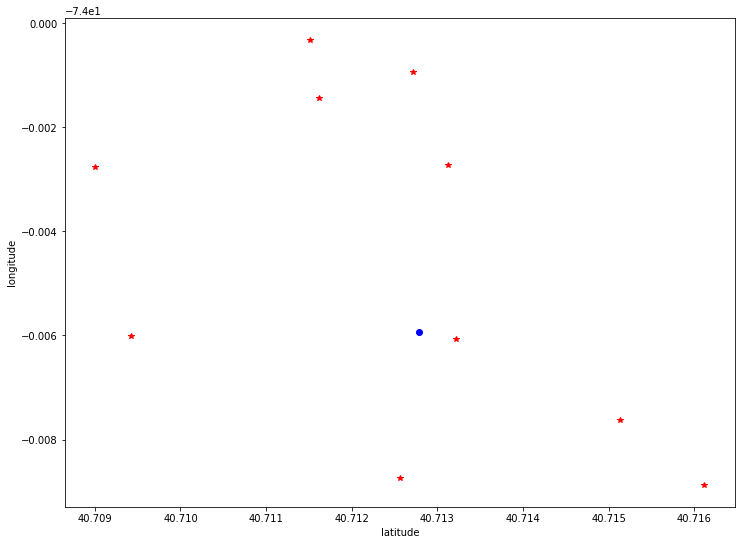

In [5]:
latitude, longitude = 40.7127837,-74.0059413
plt.plot(latitude, longitude, 'bo') # Blue 'o' shape in figure
plt.xlabel('latitude')
plt.ylabel('longitude')

lat, long = create_random_loc(latitude, longitude, 500, size=10)
print(latitude, longitude)
plt.plot(lat, long, 'r*') # all red stars in figure
for lt,lg in zip(lat, long):
    print(lt, lg)
    print("haversine distance: {}".format(haversine((latitude, longitude), (lt, lg))))

## Create the sample population of locations that is clustered around cities.
 The population varies 20KM in radius from given center point

In [6]:
# Create a distribution of location across geography (US only in this case)
radius = 20000 # 20kms of radius. A good assumption
def create_sample_population(coordinates, size=50000, p=None):
    # coordinates - list of tuple(latitude, longitude) for cities (n_clusters)
    choices = np.random.choice(len(coordinates), size=size, p=p)
    counters = Counter(choices)
    print(counters)
    sample_population = []
    for key in sorted(counters.keys()):
        lat, long = create_random_loc(latitude=coordinates[key][0], longitude=coordinates[key][1],
                                      radius=radius, size=counters[key])
        sample_population.append((lat, long))
    return sample_population

In [7]:
coordinates = list(map(lambda x: list(float(xx) for xx in x.split(',')), df['Coordinates'].values))
sample_population = create_sample_population(coordinates, size=10000, p=df['Weightage'].values)


Counter({0: 3230, 1: 1599, 2: 1064, 3: 886, 5: 635, 4: 613, 6: 587, 8: 487, 7: 478, 9: 421})


## Visualize the population created
Blue dot indicates Center of the location, red dots are random locations generated around it. Observe that points form a elliptical curve because earth is a spherical, not a circle.

## Another fun thing to do is split the location into buyers and sellers with buyers having 70% probability of searching and plot.
Note that in the figure, red dots are from buyers who are searching the property, by specifying their desired location

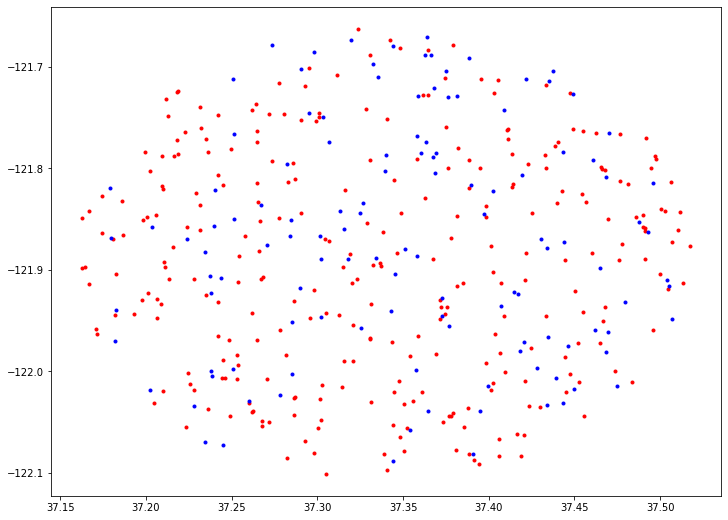

In [8]:
# assign with 70%-30% probability Buyers(Who wants to buy) and Sellers(Houses)
for sp in sample_population[9:]:
    lat, lng = sp
    buyer_seller = np.random.choice(2, size=len(lat), p=[0.7, 0.3])
    plt.plot(lat[buyer_seller==0], lng[buyer_seller==0], 'r.') # Red dots on graph
    plt.plot(lat[buyer_seller==1], lng[buyer_seller==1], 'b.') # blue dots on graph
    break
#     print(lat[buyer_seller==0], lng[buyer_seller==0])

In [9]:
for sp in sample_population[9:]:
    lat, long = sp
    for lt,ln in zip(lat, long):
        print("insert into property(latitude, longitude, bedrooms, bathrooms) values({}, {}, 3, 2);".format(lt, ln))
        break # remove this break to generate insert stmt for all queries
    break

insert into property(latitude, longitude, bedrooms, bathrooms) values(37.372091, -121.936671, 3, 2);


## Data ingestion starts
### 1. Create a Pandas dataframe containing latitude, longitude, bedrooms, bathrooms, and house price information

In [10]:
# Start of data ingestion 
locations = pd.DataFrame(columns=['latitude', 'longitude'])
lats, longs = np.array([]), np.array([])
for sp in sample_population:
    lat, long = sp
    lats = np.append(lats, lat)
    longs = np.append(longs, long)
    print(len(lats), len(longs))
locations['latitude'] = lats
locations['longitude'] = longs
locations

3230 3230
4829 4829
5893 5893
6779 6779
7392 7392
8027 8027
8614 8614
9092 9092
9579 9579
10000 10000


latitude   longitude
0     40.708807  -73.966272
1     40.671755  -74.183786
2     40.879744  -74.052698
3     40.707174  -73.966411
4     40.763782  -73.853443
...         ...         ...
9995  37.476540 -121.766153
9996  37.260009 -122.031827
9997  37.374849 -121.704689
9998  37.323807 -121.662704
9999  37.212545 -121.748762

[10000 rows x 2 columns]

## Store it to a CSV file called properties.csv

In [11]:
bedrooms = np.random.choice(np.arange(1, 5), size=10000, p=[0.2, 0.3, 0.3, 0.2]) # assign bedrooms with probabilities
bathrooms = np.random.choice(np.arange(1, 4), size=10000, p=[0.3, 0.5, 0.2]) # assign bathroom probs.
prices = np.random.lognormal(np.log(400000), 0.3, size=10000).astype(int) #create a log-normal distribution of prices
# the reference graph for lognormal is plotted down below.
locations['bedrooms'] = bedrooms
locations['bathrooms'] = bathrooms
locations['prices'] = prices
locations.to_csv('properties.csv', index=False)
locations

latitude   longitude  bedrooms  bathrooms  prices
0     40.708807  -73.966272         2          1  219671
1     40.671755  -74.183786         2          1  434579
2     40.879744  -74.052698         1          1  238879
3     40.707174  -73.966411         2          3  357441
4     40.763782  -73.853443         3          1  403495
...         ...         ...       ...        ...     ...
9995  37.476540 -121.766153         4          2  404516
9996  37.260009 -122.031827         2          2  298425
9997  37.374849 -121.704689         2          2  503495
9998  37.323807 -121.662704         1          3  438979
9999  37.212545 -121.748762         3          1  236095

[10000 rows x 5 columns]

# Plotting different distributions used and their assumptions

## Plotting the generated sample locations around a location (Los Angeles in this case)

34.0522342 -118.2436849


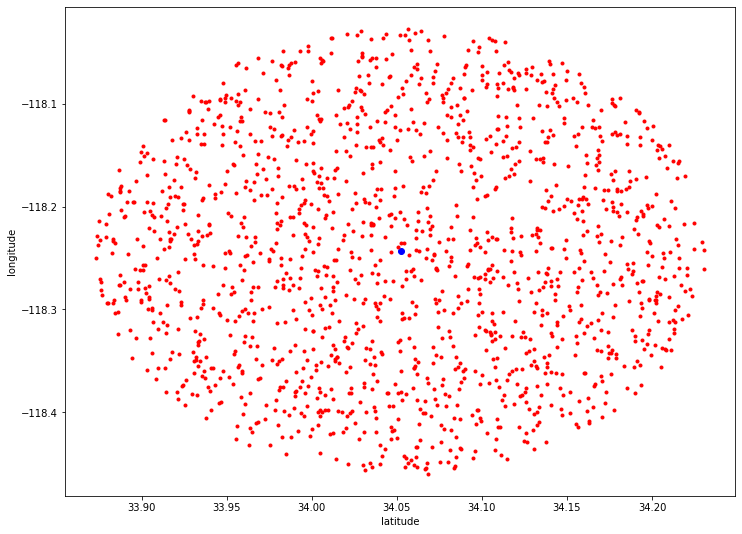

In [12]:
# plot a sample to verify density
plt.figure(figsize=(12,9))
index = 1 # the index we want to plot Los Angeles for 1. Read top10cities.csv file
latitude, longitude = coordinates[index]
print(latitude, longitude)
samples = sample_population[index]
plt.plot(latitude, longitude, 'bo')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.plot(samples[0], samples[1], 'r.')

## Log-Normal distribution of housing prices

(array([2.340e+02, 2.523e+03, 3.695e+03, 2.203e+03, 9.230e+02, 3.040e+02,
        8.100e+01, 2.100e+01, 1.300e+01, 3.000e+00]),
 array([ 113997. ,  224154.3,  334311.6,  444468.9,  554626.2,  664783.5,
         774940.8,  885098.1,  995255.4, 1105412.7, 1215570. ]),
 <a list of 10 Patch objects>)

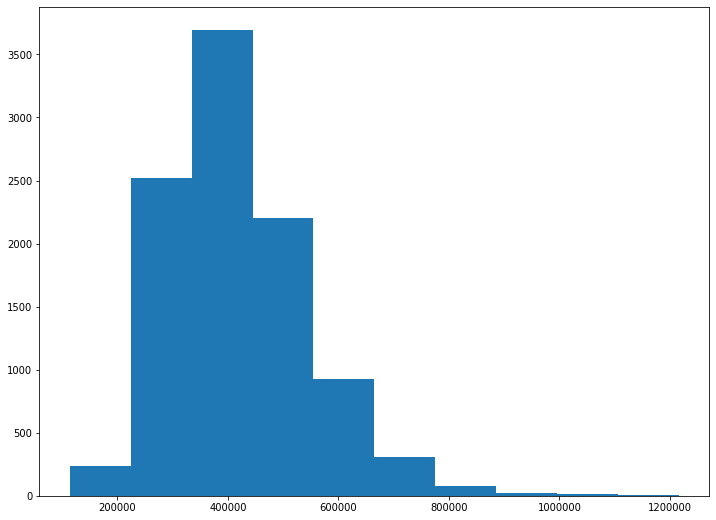

In [13]:
# create housing market with lognormal distribution with log(400000) as mean price, 0.3 stdeviation
plt.hist(np.random.lognormal(np.log(400000), 0.3, size=10000).astype(int))

## Multinomial distribution for generating bedrooms, bathrooms


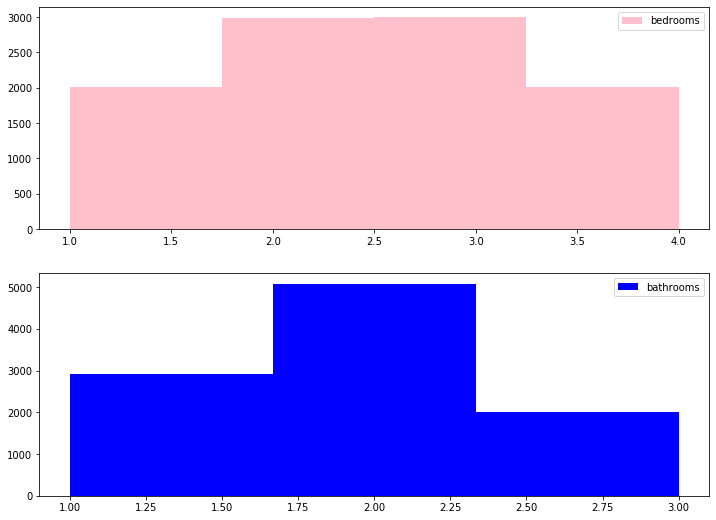

In [14]:
bedrooms = np.random.choice(np.arange(1, 5), size=10000, p=[0.2, 0.3, 0.3, 0.2]) # assign bedrooms with probabilities
bathrooms = np.random.choice(np.arange(1, 4), size=10000, p=[0.3, 0.5, 0.2]) # assign bathroom probs.
plt.subplot(211)
plt.hist(bedrooms, bins=4, color='pink')
plt.legend(['bedrooms'])
plt.subplot(212)
plt.hist(bathrooms, bins=3, color='blue')
plt.legend(['bathrooms'])

# Stress testing
### test with 1000 concurrent connection request the resource with different parameters

In [18]:
def post_req(url, jsonbody):
    return requests.post(url, json=jsonbody)
async def stress_test(max_workers=20, nrequests=100):    
    # application stress testing
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        loop =  asyncio.get_event_loop()
        futures = []
        for i in range(nrequests):
            bedrooms = np.random.choice(np.arange(1, 5), p=[0.2, 0.3, 0.3, 0.2]) # assign bedrooms with probabilities
            bathrooms = np.random.choice(np.arange(1, 4), p=[0.3, 0.5, 0.2]) # assign bathroom probs.
            prices = np.random.lognormal(np.log(400000), 0.3) #create a log-normal distribution of prices
            limit = np.random.randint(5, 100)
            offset = np.random.randint(0, 20)
            # choose a random location from sample population
            sp = sample_population[np.random.choice(len(sample_population))] # will have [lt1, lt2, ..], [lg1, lg2, ..]
            idx = np.random.choice(len(sp[0]))

            lat = sp[0][idx]
            lng = sp[1][idx]

            payload = {
                "latitude": lat,
                "longitude": lng,
                "minprice": int(prices*0.76), 
                "maxprice": int(prices*1.45),
                "minbedrooms": int(bedrooms),
                "maxbedrooms": int(bedrooms+2),
                "minbathrooms": int(bathrooms),
                "maxbathrooms": int(bathrooms+2)
            }
            url=f"http://127.0.0.1:5000/api/v1/property/search?start={offset}&limit={limit}"
            print(f"Url: {url}")

            futures.append( 
                loop.run_in_executor(
                    executor, 
                    post_req, 
                    url,
                    payload
                )
            )
        responses = []
        for response in await asyncio.gather(*futures):
            responses.append(response.elapsed.total_seconds())
        print("took " + str(np.average(responses)) + " seconds on average per request")



loop = asyncio.get_event_loop()
loop.run_until_complete(stress_test(nrequests=100))


Url: http://127.0.0.1:5000/api/v1/property/search?start=14&limit=34
Url: http://127.0.0.1:5000/api/v1/property/search?start=14&limit=28
Url: http://127.0.0.1:5000/api/v1/property/search?start=2&limit=46
Url: http://127.0.0.1:5000/api/v1/property/search?start=6&limit=52
Url: http://127.0.0.1:5000/api/v1/property/search?start=7&limit=36
Url: http://127.0.0.1:5000/api/v1/property/search?start=3&limit=58
Url: http://127.0.0.1:5000/api/v1/property/search?start=19&limit=12
Url: http://127.0.0.1:5000/api/v1/property/search?start=15&limit=16
Url: http://127.0.0.1:5000/api/v1/property/search?start=9&limit=31
Url: http://127.0.0.1:5000/api/v1/property/search?start=18&limit=33
Url: http://127.0.0.1:5000/api/v1/property/search?start=8&limit=77
Url: http://127.0.0.1:5000/api/v1/property/search?start=12&limit=76
Url: http://127.0.0.1:5000/api/v1/property/search?start=3&limit=51
Url: http://127.0.0.1:5000/api/v1/property/search?start=4&limit=14
Url: http://127.0.0.1:5000/api/v1/property/search?start=

# SQL queries

## these queries can be used to debug quickly through database connection

In [16]:
"""
select id, dist, price, geog, distance_weight, price_weight, distance_weight+price_weight as total_weight
from (
select distance_table.id, dist, price, geog,
-- if distance is less than 2 miles, full score
case when (dist<2) then 0.3
-- if distance is mroe than 10 miles, no score
 when (dist>10) then 0
-- if distance is between 2 & 10 miles. The score decreases with increase in distance
else  (1- (dist-2)/(10-2))*0.3
end 
as distance_weight,

-- if price is less than 110% of the search price. full score
case when (1.0*price/390000.0 < 1.10) then 0.3
-- if price is more than 150% of the search price, ignore entries
when (1.0*price/390000.0 > 1.5) then 0 -- limit to 150% of ask price
-- if price is in between this, the score decreases with increase in price. 
else (1 - (price/390000.0 - 1.1)/(1.5-1.1))*0.3
end
as price_weight

from 
-- first select locations nearest to the location. max 100
(SELECT id, st_distance(geog, ST_POINT(-118.1207504272461,34.11167526245117))*0.000621371192 as dist, latitude, longitude, geog 
from property 
where st_distance(geog, ST_POINT(-118.1207504272461,34.11167526245117)) < 16093.44
order by geog <-> ST_POINT(-118.1207504272461,34.11167526245117)
limit 100 offset 0)  as distance_table

inner join 

-- select prices of all the houses, regardless of location.
-- this is inner-joined with shortest-location table to fetch only desired results
(select  id, price
from property
where price < 390000.0*1.5
order by price asc) as price_table
on distance_table.id=price_table.id
) as distancepricetable

-- to calculate the total_weight, we need distance_weight, and price_weight. we are interested in only first n entries
order by total_weight desc limit 30;

"""

'\nselect id, dist, price, geog, distance_weight, price_weight, distance_weight+price_weight as total_weight\nfrom (\nselect distance_table.id, dist, price, geog,\n-- if distance is less than 2 miles, full score\ncase when (dist<2) then 0.3\n-- if distance is mroe than 10 miles, no score\n when (dist>10) then 0\n-- if distance is between 2 & 10 miles. The score decreases with increase in distance\nelse  (1- (dist-2)/(10-2))*0.3\nend \nas distance_weight,\n\n-- if price is less than 110% of the search price. full score\ncase when (1.0*price/390000.0 < 1.10) then 0.3\n-- if price is more than 150% of the search price, ignore entries\nwhen (1.0*price/390000.0 > 1.5) then 0 -- limit to 150% of ask price\n-- if price is in between this, the score decreases with increase in price. \nelse (1 - (price/390000.0 - 1.1)/(1.5-1.1))*0.3\nend\nas price_weight\n\nfrom \n-- first select locations nearest to the location. max 100\n(SELECT id, st_distance(geog, ST_POINT(-118.1207504272461,34.11167526245

## Create the geography index. Crucial for performance

In [17]:
# copy CSV to postgres 
# \copy property(latitude, longitude, bedrooms, bathrooms) from '/properties.csv' with CSV DELIMITER ',' HEADER;
# create the index for faster query
"""
CREATE INDEX  property_geog_idx
ON property
using GIST(geog);
"""

#Drop the index created.
"""
drop index property_geog_idx ;
"""
#hey

'\ndrop index property_geog_idx ;\n'